# Colab env settings

In [1]:
!git clone https://github.com/bochendong/car_racing.git

fatal: destination path 'car_racing' already exists and is not an empty directory.


In [2]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install wandb
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

In [3]:
import numpy as np

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from torch.autograd import Function

import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [4]:
!pip install box2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [6]:
%cd car_racing

/content/car_racing


In [7]:
import car_racing as cr
import replay_memory as rm

In [9]:
import os
import glob

if (os.path.exists("./output")) == False:
    os.mkdir("output")

for epoch in range (3000):
    files = glob.glob("./output/*.png")

    for f in files:
        os.remove(f)

# Car_racing Enviorment settings

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
env_green = gnwrapper.Animation(cr.CarRacing())
env_green = cr.CarRacing(color = 'g')
obs = env_green.reset()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
discrete_actions = {0 : np.array([0,0,0]),       # do nothing
                                 1 : np.array([-1,0,0]),      # steer sharp left
                                 2 : np.array([1,0,0]),       # steer sharp right
                                 3 : np.array([-0.5,0,0]),    # steer left
                                 4 : np.array([0.5,0,0]),     # steer right
                                 5 : np.array([0,1,0]),       # accelerate 100%
                                 6 : np.array([0,0.5,0]),     # accelerate 50%
                                 7 : np.array([0,0.25,0]),    # accelerate 25%
                                 8 : np.array([0,0,1]),       # brake 100%
                                 9 : np.array([0,0,0.5]),     # brake 50%
                                 10 : np.array([0,0,0.25])}   # brake 25%

def get_obs(env):
    n_actions = len(discrete_actions)
    for i in range (0, 40):
        action = torch.randint(low=0, high=11, size=(1,))
        action_transfered = discrete_actions.get(int(action[0]))

        obs, reward, done, _ = env.step([action_transfered[0], action_transfered[1], action_transfered[2]])

    return obs

In [13]:
import random

def rand_env(s):
    red_channel = 102
    green_channel = 102
    blue_channel = 102

    while (red_channel == 102 and green_channel == 102 and blue_channel == 102):
        add_green = random.randint(0, 1)
        add_red = random.randint(0, 1)
        add_blue = random.randint(0, 1)

        if (add_red):
            red_channel = random.randint(150, 229)
        if (add_green):
            green_channel = random.randint(150, 229)
        if (add_blue):
            blue_channel = random.randint(150, 229)


    for i in range (96):
        for j in range (96):
            if (s[i][j][0] == s[i][j][1] == s[i][j][2]):
                  continue
            elif (s[i][j][1] == 204):
                  s[i][j][0] = red_channel
                  s[i][j][1] = green_channel
                  s[i][j][2] = blue_channel
            elif (s[i][j][1] == 230):
                  s[i][j][0] = red_channel + 26
                  s[i][j][1] = green_channel + 26
                  s[i][j][2] = blue_channel + 26
    return s

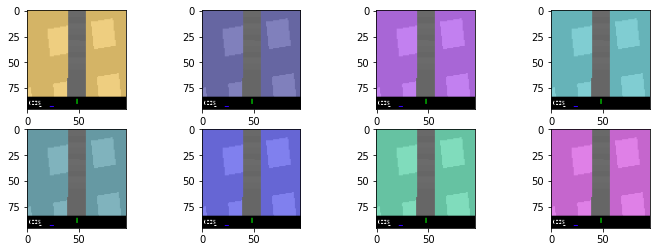

In [14]:
rand_envs = []
test_state = get_obs(env_green)

for i in range (8):
    green_copy = test_state.copy()
    ss = rand_env(green_copy)
    rand_envs.append(ss)

f, axs = plt.subplots(2, 4, figsize = (12, 4))
axs = axs.flatten()

for img, ax in zip(rand_envs, axs):
    ax.imshow(img)


# Random env

In [15]:
class Rand_Env():
    def __init__(self, color, seed = 0):
        self.env = gnwrapper.Animation(cr.CarRacing(color = color))
        self.env = cr.CarRacing(color = color)
        self.color = color
        self.env.seed(seed)
        self.reward_threshold = 1000

    def rand_state(self, state):
        s = state.copy()

        red_channel, green_channel, blue_channel  = 102, 102, 102

        while (red_channel == 102 and green_channel == 102 and blue_channel == 102):
            add_green = random.randint(0, 1)
            add_red = random.randint(0, 1)
            add_blue = random.randint(0, 1)
            if (add_red): red_channel = random.randint(150, 229)
            if (add_green): green_channel = random.randint(150, 229)
            if (add_blue): blue_channel = random.randint(150, 229)

        for i in range (96):
            for j in range (96):
                if (s[i][j][0] == s[i][j][1] == s[i][j][2]):
                      continue
                elif (s[i][j][1] == 204):
                      s[i][j][0] = red_channel
                      s[i][j][1] = green_channel
                      s[i][j][2] = blue_channel
                elif (s[i][j][1] == 230):
                      s[i][j][0] = red_channel + 26
                      s[i][j][1] = green_channel + 26
                      s[i][j][2] = blue_channel + 26
        return s

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False

        img_rgb = self.env.reset()
        rand_img_rgb = self.rand_state(img_rgb)

        img_rgb = img_rgb / 128. - 1
        rand_img_rgb = rand_img_rgb / 128. - 1

        self.stack = [img_rgb] * 4
        self.rand_stack = [rand_img_rgb] * 4

        return np.array(self.stack), np.array(self.rand_stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)

            if die: reward += 100

            if self.color == 'g' and np.mean(img_rgb[:, :, 1]) > 185.0:
                  reward -= 0.05

            total_reward += reward

            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break

        rand_img_rgb = self.rand_state(img_rgb)

        img_rgb = img_rgb / 128. - 1
        rand_img_rgb = rand_img_rgb / 128. - 1

        self.stack.pop(0)
        self.stack.append(img_rgb)

        self.rand_stack.pop(0)
        self.rand_stack.append(rand_img_rgb)

        assert len(self.stack) == 4
        assert len(self.rand_stack) == 4

        return np.array(self.stack), np.array(self.rand_stack), total_reward, done, die

    def step_eval(self, action):
        img_rgb, reward, done, _ = self.env.step(action)

        rand_img_rgb = self.rand_state(img_rgb)

        rand_img_rgb = rand_img_rgb / 128. - 1
        img_rgb = img_rgb / 128. - 1

        self.stack.pop(0)
        self.stack.append(img_rgb)

        self.rand_stack.pop(0)
        self.rand_stack.append(rand_img_rgb)
        
        return np.array(self.stack), np.array(self.rand_stack), reward, done, _

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

# DANN

In [16]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None  

class DANN(nn.Module):
    def __init__(self, num_out):
        super(DANN, self).__init__()
        self.sketch = nn.Sequential(
            nn.Conv3d(4, 4, kernel_size=(1, 1, 3), stride=1),
            nn.ReLU(),
        )
        self.feature = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),
        )

        self.cnn_base = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(True),
            nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, num_out),
        )

        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)
      
    def forward(self, input, a = 0.1):
        sketch = self.sketch(input)
        sketch = torch.squeeze(sketch)

        feature = self.feature(sketch)

        out = self.cnn_base(feature)
        out = out.view(-1, 256)
        v = self.v(out)
        out = self.fc(out)

        alpha = self.alpha_head(out) + 1
        beta = self.beta_head(out) + 1

        feature = feature.view(-1, 64 * 5 * 5)
        reverse_feature = ReverseLayerF.apply(feature, a)
        domain_output = self.domain_classifier(reverse_feature)

        return (alpha, beta), v, domain_output

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

# Random Env Training

## Random Env Agent

In [17]:
class rand_Agent():
    max_grad_norm = 0.5
    clip_param = 0.1
    ppo_epoch = 10

    transition = np.dtype([('s', np.float64, (4, 96, 96, 3)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (4, 96, 96, 3))])
    target_transition =  np.dtype([('0', np.float64, (4, 96, 96, 3))])

    def __init__(self, net, criterion, optimizer, buffer_capacity = 2000, batch_size = 128):
        self.net = net
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.criterion = criterion
        self.optimizer = optimizer

        self.source_buffer = np.empty(self.buffer_capacity, dtype=self.transition)
        self.target_buffer = np.empty(self.buffer_capacity, dtype=self.target_transition)
        self.counter = 0

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            out = self.net.sketch(state)
            out = torch.squeeze(out)
            out = self.net.feature(out)

            out = self.net.cnn_base(out)
            out = out.view(-1, 256)
            out = self.net.fc(out)
            alpha = self.net.alpha_head(out) + 1
            beta = self.net.beta_head(out) + 1

        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def store(self, transition, target_transition):
        self.source_buffer[self.counter] = transition
        self.target_buffer[self.counter] = target_transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True

        return False

    def update(self, epoch, eta = 0.1):
        s = torch.tensor(self.source_buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.source_buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.source_buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.source_buffer['s_'], dtype=torch.double).to(device)
        old_a_logp = torch.tensor(self.source_buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        target_s = torch.tensor(self.target_buffer['0'], dtype=torch.double).to(device)

        source_domain_label = torch.zeros(self.batch_size).long()
        target_domain_label = torch.ones(self.batch_size).long()
        source_domain_label = source_domain_label.to(device)
        target_domain_label = target_domain_label.to(device)

        with torch.no_grad():
            target_v = r + 0.99 * self.net(s_)[1]
            adv = target_v - self.net(s)[1]

        for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, True):
            image_array = []
  
            image = self.net.sketch(s[index])[16][0]
            image = image.reshape(96, 96)
            image = image.cpu().detach().numpy()
            image_array.append(image)

            for i in range (4):
              image = self.net.sketch(target_s[index])[16 + i][0]
              image = image.reshape(96, 96)
              image = image.cpu().detach().numpy()
              image_array.append(image)

            f, axs = plt.subplots(1, 5, figsize = (12, 4))
            for img, ax in zip(image_array, axs):
                ax.imshow(img)
            f.savefig('./output/%03d.png' % epoch)
            plt.close(f)
            break
  
        for _ in range(self.ppo_epoch):
            total = 0
            source_domain_correct = 0
            tagret_domain_correct = 0
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, True):
                total += self.batch_size
                loss = 0

                (alpha, beta), v, domain_out = self.net(s[index], eta)
                source_domain_loss = self.criterion(domain_out, source_domain_label)

                _, predicted = torch.max(domain_out.data, 1)
                source_domain_correct += predicted.eq(source_domain_label.data).cpu().sum().item()

                _, _,  domain_out = self.net(target_s[index], eta)
                target_domain_loss = self.criterion(domain_out, target_domain_label)

                _, predicted = torch.max(domain_out.data, 1)
                tagret_domain_correct += predicted.eq(target_domain_label.data).cpu().sum().item()

                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])
                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])

                loss += action_loss + 2. * value_loss + source_domain_loss + target_domain_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            print ("Source Correct: %.2f, Target Correct: %.2f" % (source_domain_correct / total, tagret_domain_correct / total))


## Random env training

In [18]:
source_env = Rand_Env(color = 'g', seed = 0)

criterion = nn.CrossEntropyLoss().to(device)
net = DANN(num_out = 2).double().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

agent = rand_Agent(net = net,  criterion = criterion, 
              optimizer = optimizer, buffer_capacity = 3000, batch_size = 64)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
training_records = []
running_score = 0

for i_ep in range(3000):
    score = 0
    state, target_state = source_env.reset()

    if (i_ep < 500): eta = 0.5
    elif (i_ep < 1000): eta = 0.4
    elif (i_ep < 1500): eta = 0.3
    elif (i_ep < 2000): eta = 0.2
    else: eta = 0.1

    for t in range(1000):
        action, a_logp = agent.select_action(state)
        state_, target_state_, reward, done, die = source_env.step(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))
        score += reward

        should_update = agent.store((state, action, a_logp, reward, state_), (target_state, ))

        if should_update: 
            agent.update(epoch = i_ep, eta = eta)

        state = state_
        target_state = target_state_

        if done or die: break

    running_score = running_score * 0.99 + score * 0.01
    if (i_ep % 10 == 0):
        print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
        

Ep 0	Last score: -23.52	Moving average score: -0.24
retry to generate track (normal if there are not manyinstances of this message)
Ep 10	Last score: -18.09	Moving average score: -1.86
retry to generate track (normal if there are not manyinstances of this message)
Ep 20	Last score: -17.93	Moving average score: -3.37
Source Correct: 0.69, Target Correct: 0.73
Source Correct: 0.73, Target Correct: 0.63
Source Correct: 0.63, Target Correct: 0.55
Source Correct: 0.59, Target Correct: 0.54
Source Correct: 0.67, Target Correct: 0.43
Source Correct: 0.62, Target Correct: 0.44
Source Correct: 0.57, Target Correct: 0.49
Source Correct: 0.59, Target Correct: 0.48
Source Correct: 0.58, Target Correct: 0.45
Source Correct: 0.59, Target Correct: 0.45
Ep 30	Last score: -18.04	Moving average score: -4.27
retry to generate track (normal if there are not manyinstances of this message)
Ep 40	Last score: -17.89	Moving average score: -5.60
retry to generate track (normal if there are not manyinstances of 